In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import shutil
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
!pip install wandb -qU
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 kB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.1 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
# manual_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                          std=[0.229, 0.224, 0.225])
# ])

manual_transforms = transforms.ToTensor()

In [5]:
#rename root and test dirs based on dataset
root_dir = '/content/fmnist_train_data'

os.makedirs(root_dir, exist_ok=True)
# change the range to number of classes in dataset
for i in range(10):
    os.makedirs(os.path.join(root_dir, str(i)), exist_ok=True)

In [6]:
trainset = torchvision.datasets.FashionMNIST(root=root_dir, train=True, download=True, transform=manual_transforms)
trainloader = DataLoader(trainset, batch_size=1, shuffle=True)

100%|██████████| 26421880/26421880 [00:03<00:00, 8449931.20it/s] 


Extracting /content/fmnist_train_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/fmnist_train_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 173933.71it/s]


Extracting /content/fmnist_train_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/fmnist_train_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1182665.95it/s]


Extracting /content/fmnist_train_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/fmnist_train_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5958133.83it/s]

Extracting /content/fmnist_train_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/fmnist_train_data/FashionMNIST/raw



In [7]:
class_names = trainset.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [8]:
def save_images_to_folders(dataset, root_dir):
    for idx, (image, label) in enumerate(tqdm(dataset)):
        label_dir = os.path.join(root_dir, str(label))
        img_path = os.path.join(label_dir, f'{idx}.png')
        torchvision.utils.save_image(image, img_path)

In [9]:
save_images_to_folders(trainset, root_dir)

100%|██████████| 60000/60000 [00:42<00:00, 1426.67it/s]


In [10]:
shutil.rmtree('/content/fmnist_train_data/FashionMNIST')
# os.remove('/content/cifar100_train_data/cifar-100-python.tar.gz')

In [11]:
# test_dir = '/content/fmnist_test_data'
# os.makedirs(test_dir, exist_ok=True)
# for i in range(10):
#     os.makedirs(os.path.join(test_dir, str(i)), exist_ok=True)

# testset = torchvision.datasets.FashionMNIST(root=test_dir, train=False, download=True, transform=manual_transforms)
# testloader = DataLoader(trainset, batch_size=1, shuffle=True)

In [12]:
# save_images_to_folders(testset, test_dir)

In [13]:
# shutil.rmtree('/content/fmnist_test_data/FashionMNIST')
# os.remove('/content/cifar100_test_data/cifar-100-python.tar.gz')

In [14]:
import os
import pandas as pd

# initialise annotation file names here

train_annotation = 'annotations_fashion_train.csv'
# test_annotation = 'annotations_fashion_test.csv'

def create_annotations_csv(root_dir, output_file):
    data = []

    for label in os.listdir(root_dir):
        label_dir = os.path.join(root_dir, label)
        if os.path.isdir(label_dir):
            for file_name in os.listdir(label_dir):
                file_path = os.path.join(label_dir, file_name)
                if os.path.isfile(file_path):
                    data.append([f"{label}/{file_name}", label])

    df = pd.DataFrame(data, columns=['filepath', 'label'])

    df.to_csv(output_file, index=False)

    print(f"{output_file} file created successfully.")

create_annotations_csv(root_dir, train_annotation)
# create_annotations_csv(test_dir, test_annotation)

annotations_fashion_train.csv file created successfully.


In [15]:
config = {
    "learning_rate": 0.01,
    "batch_size": 64,
    "epochs": 5,
}

In [17]:
project_name = 'Confusion Matrix Experiments'
run_name = 'FashionMNIST_label_studio'
github_url_base = 'https://github.com/Aadharsh1/ML-Deep-Learning/blob/main/Weights_Biases'
file_name = f'{run_name}.ipynb'
notebook_link = f'{github_url_base}/{project_name}/{file_name}'

run = wandb.init(
    project=project_name,
    name=run_name,
    notes=notebook_link,
    config=config,
    )

annotations_path = f'/content/{train_annotation}'
labels_at = wandb.Artifact(f"{train_annotation}", type="dataset")
labels_at.add_reference(f'file://{annotations_path}')
run.log_artifact(labels_at)

# annotations_path = f'/content/{test_annotation}'
# labels_at = wandb.Artifact(f"{test_annotation}", type="dataset")
# labels_at.add_reference(f'file://{annotations_path}')
# run.log_artifact(labels_at)

wandb: Currently logged in as: aadharshr-2022 (aadharshr-2022-Singapore Management University). Use `wandb login --relogin` to force relogin


<Artifact annotations_fashion_train.csv>

In [18]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import pandas as pd
from PIL import Image

class NewDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        #remeber to change 'RGB' to 'L' for greyscale images and vice versa
        image = Image.open(img_path).convert("L")
        label = int(self.img_labels.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label, img_path

In [19]:
train_dataset = NewDataset(annotations_file=f'/content/{train_annotation}', img_dir=root_dir, transform=manual_transforms)
# test_dataset = NewDataset(annotations_file=f'/content/{test_annotation}', img_dir=test_dir, transform=manual_transforms)



In [19]:
# from torch.utils.data import DataLoader, random_split
# calibration_size = int(0.02*len(train_dataset))
# remaining_size = len(train_dataset) - calibration_size
# calibration_set, train_set = random_split(train_dataset, [calibration_size, remaining_size])


In [20]:
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
# calib_loader = DataLoader(calibration_set, batch_size=config["batch_size"], shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False)

In [22]:
class model1(nn.Module):
  def __init__(self, in_shape, hidden_units, out_shape):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=in_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(490, out_shape)
    )

  def forward(self, x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

model = model1(1, 10, 10).to(device)

In [23]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model.parameters(), lr=config['learning_rate'])

def accuracy_function(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [24]:
from tqdm.auto import tqdm
def train_function(model, device, train_dataloader, loss_function, optimizer):
  model.train()
  model = model.to(device)
  training_loss = 0
  trng_acc = 0
  for X_train, y_train, img_path in tqdm(train_dataloader):
    X_train, y_train = X_train.to(device), y_train.to(device)
    y_train_logits = model(X_train)
    loss = loss_function(y_train_logits, y_train)
    training_loss += loss
    trng_acc += accuracy_function(y_train, torch.argmax(y_train_logits, dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  # find average loss per batch
  return (training_loss/len(train_dataloader), trng_acc/len(train_dataloader))


def validate_function(model, device, validation_dataloader, loss_function, accuracy_function):
  model.eval()
  model = model.to(device)
  validation_loss = 0
  validation_acc = 0

  with torch.inference_mode():
    for X_val, y_val, img_path in tqdm(validation_dataloader):
      X_val , y_val = X_val.to(device), y_val.to(device)
      val_logits = model(X_val)
      val_pred = torch.argmax(val_logits, dim=1)
      validation_acc += accuracy_function(y_val, val_pred)
      validation_loss += loss_function(val_logits, y_val)
  return validation_loss/len(validation_dataloader), validation_acc/len(validation_dataloader)

In [26]:
epochs = config['epochs']
for epoch in range(epochs):
  train_loss, trng_acc = train_function(model, device, train_loader, loss_fn, optimizer)
  # val_loss, val_acc = validate_function(model, device, test_loader, loss_fn, accuracy_function)
  wandb.log({
        'training_loss': train_loss,
        'training_accuracy': trng_acc
        # ,
        # 'test_loss': val_loss,
        # 'test_accuracy': val_acc
    })
  print(f'Epoch {epoch+1}: Training Loss: {train_loss:.4f}, Training Accuracy: {trng_acc:.4f}')

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1: Training Loss: 1.4317, Training Accuracy: 50.0333


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2: Training Loss: 0.6643, Training Accuracy: 76.1061


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3: Training Loss: 0.5534, Training Accuracy: 80.1772


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4: Training Loss: 0.4812, Training Accuracy: 82.8225


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5: Training Loss: 0.4423, Training Accuracy: 84.2217


In [27]:
train_loader1 = DataLoader(train_dataset, batch_size=1, shuffle=True)

In [28]:
y_preds = []
y_true = []

model.eval()
with torch.inference_mode():
  for img, label, _ in tqdm(train_loader1):
    img, label = img.to(device), label.to(device)
    outputs = model(img)
    _, pred = torch.max(outputs, dim=1)
    y_preds.append(pred.item())
    y_true.append(label.item())

  0%|          | 0/60000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [29]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 16.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

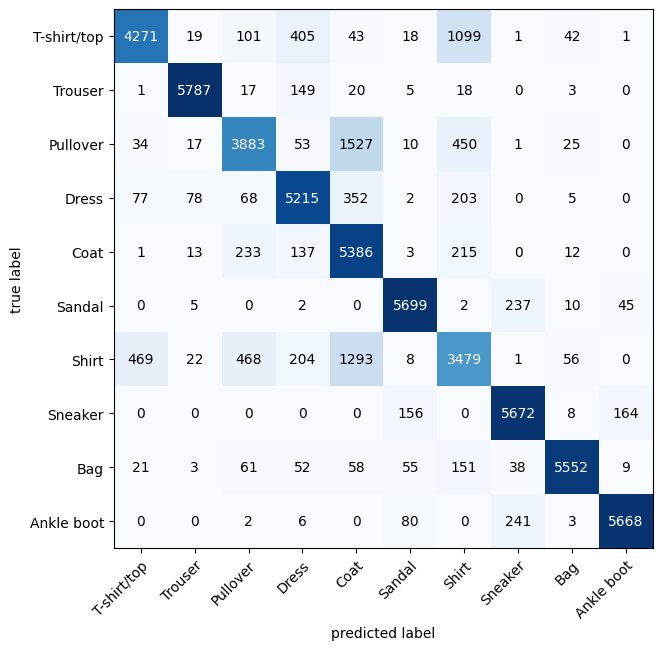

In [30]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=torch.tensor(y_preds),
                         target=torch.tensor(y_true))


fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
);

In [31]:
wandb.log({
    'confusion_matrix_before': wandb.Image(fig)
})

In [32]:
import shutil
import torch
from torchvision import transforms
from torch.utils.data import DataLoader

# Create directories for misclassified images
# os.makedirs('/content/fmnist_train_data/misclassified_tshirt_as_shirt', exist_ok=True)
# os.makedirs('/content/fashion_train_data/misclassified_shirt_as_tshirt', exist_ok=True)
os.makedirs('/content/fmnist_train_data/misclassified_tshirt_as_bag', exist_ok=True)

In [36]:
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [37]:
tshirt_index = 0
shirt_index = 6
bag_index= 8

In [38]:
model.eval()
with torch.no_grad():
    for images, labels, paths in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for img, true_label, pred_label, img_path in zip(images, labels, predicted, paths):
            if true_label.item() == tshirt_index and pred_label.item() == bag_index:
                shutil.move(img_path, '/content/fmnist_train_data/misclassified_tshirt_as_bag')
            # elif true_label.item() == shirt_index and pred_label.item() == tshirt_index:
            #     shutil.move(img_path, '/content/fashion_train_data/misclassified_shirt_as_tshirt')


In [39]:
len(os.listdir('/content/fmnist_train_data/misclassified_tshirt_as_bag'))
# code works as u can see from the confusion matrix, there are 42 tshirts misclassifed as bag

42

In [40]:
create_annotations_csv(root_dir, 'new_train_annotations.csv')

new_train_annotations file created successfully.


In [42]:
#zip the folder/s that i want to re label and download them locally and re label them in label studio

import shutil

folder_path = "/content/fmnist_train_data/misclassified_tshirt_as_bag"

zip_file_path = "/content/misclassified_tshirt_as_bag.zip"

shutil.make_archive(zip_file_path.replace('.zip', ''), 'zip', folder_path)

zip_file_path

'/content/misclassified_tshirt_as_bag.zip'

In [45]:
# code for formatting csv from label studio to be the same format as our original file
# upload the csv file from label studio first

path_to_uploaded_csv_file = '/content/label_studio_tshirt_bag.csv'

import pandas as pd
csv_file_path = path_to_uploaded_csv_file
df = pd.read_csv(csv_file_path)
df['filepath'] = df['image'].apply(lambda x: x.split('=')[-1])
df['label'] = df['label'].apply(lambda x: class_names.index(x))
df = df[['filepath', 'label']]

output_csv_path = '/content/label_studio_shirt_bag_formatted.csv'
df.to_csv(output_csv_path, index=False)
print(f"Processed CSV saved to {output_csv_path}")

Processed CSV saved to /content/label_studio_shirt_bag_formatted.csv


In [47]:
#merging the 2 files together
import pandas as pd

original_csv_path = 'new_train_annotations.csv'
new_labels_csv_path = 'label_studio_shirt_bag_formatted.csv'
updated_csv_path = 'updated_train_labels.csv'

original_df = pd.read_csv(original_csv_path)
new_labels_df = pd.read_csv(new_labels_csv_path)

merged_df = original_df.merge(new_labels_df, on='filepath', how='left', suffixes=('', '_new'))

merged_df['label'] = merged_df['label_new'].combine_first(merged_df['label'])

merged_df.drop(columns=['label_new'], inplace=True)

merged_df['label'] = merged_df['label'].astype(int)

merged_df.to_csv(updated_csv_path, index=False)

print(f"Updated original CSV saved to {updated_csv_path}")


Updated original CSV saved to updated_train_labels.csv


In [48]:
annotations_path = f'/content/{updated_csv_path}'
labels_at = wandb.Artifact(f"{updated_csv_path}", type="dataset")
labels_at.add_reference(f'file://{annotations_path}')
run.log_artifact(labels_at)

<Artifact updated_train_labels.csv>

In [49]:
#load in training data again with new annotation file
new_train_dataset = NewDataset(annotations_file=f'/content/{updated_csv_path}', img_dir=root_dir, transform=manual_transforms)

In [50]:
new_train_loader = DataLoader(new_train_dataset, batch_size=config["batch_size"], shuffle=True)

In [51]:
model2 = model1(1, 10, 10).to(device)

In [52]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model2.parameters(), lr=config['learning_rate'])

def accuracy_function(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [53]:
epochs = config['epochs']
for epoch in range(epochs):
  train_loss, trng_acc = train_function(model2, device, new_train_loader, loss_fn, optimizer)
  wandb.log({
        'new_raining_loss': train_loss,
        'new_training_accuracy': trng_acc
        # ,
        # 'test_loss': val_loss,
        # 'test_accuracy': val_acc
    })
  print(f'Epoch {epoch+1}: Training Loss: {train_loss:.4f}, Training Accuracy: {trng_acc:.4f}')

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1: Training Loss: 1.7875, Training Accuracy: 37.1552


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2: Training Loss: 0.6331, Training Accuracy: 77.1172


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3: Training Loss: 0.5046, Training Accuracy: 81.8430


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4: Training Loss: 0.4540, Training Accuracy: 83.6171


  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5: Training Loss: 0.4263, Training Accuracy: 84.7814


In [54]:
train_loader2 = DataLoader(new_train_dataset, batch_size=1, shuffle=True)

In [55]:
y_preds = []
y_true = []

model2.eval()
with torch.inference_mode():
  for img, label, _ in tqdm(train_loader2):
    img, label = img.to(device), label.to(device)
    outputs = model2(img)
    _, pred = torch.max(outputs, dim=1)
    y_preds.append(pred.item())
    y_true.append(label.item())

  0%|          | 0/60000 [00:00<?, ?it/s]

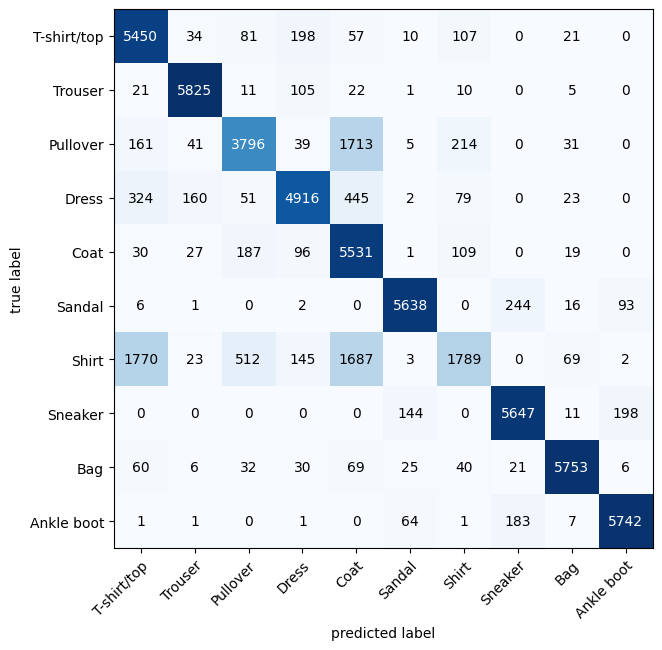

In [56]:
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=torch.tensor(y_preds),
                         target=torch.tensor(y_true))


fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
);

In [62]:
wandb.log({
    'confusion_matrix_after': wandb.Image(fig)
})

In [63]:
project_name = wandb.run.project
run_name = wandb.run.name
# change notebook name according to name of current notebook
notebook_path = '/content/drive/MyDrive/Colab Notebooks/fmnist_annotations.ipynb'

In [64]:
url_path = '/content/drive/MyDrive/github_url.txt'
with open(url_path, 'r') as file:
    github_url = file.read().strip()

In [65]:
import os
import subprocess
import shutil
directory = project_name
file_name = f"{run_name}.ipynb"
file_path = os.path.join('/content/ML-Deep-Learning/Weights_Biases', directory, file_name)

In [ ]:
#shutil.rmtree('/content/ML-Deep-Learning')

In [66]:
repo_path = '/content/ML-Deep-Learning'
if not os.path.exists(repo_path):
    subprocess.run(["git", "clone", github_url, repo_path])

os.chdir(repo_path)

In [67]:
project_directory = os.path.join('Weights_Biases', directory)
if not os.path.exists(project_directory):
    os.makedirs(project_directory)
    print(f"Directory '{project_directory}' created.")
else:
    print(f"Directory '{project_directory}' already exists.")

Directory 'Weights_Biases/Confusion Matrix Experiments' created.


In [68]:
shutil.copyfile(notebook_path, file_path)

'/content/ML-Deep-Learning/Weights_Biases/Confusion Matrix Experiments/FashionMNIST.ipynb'

In [69]:
!git config --global user.email "aadharshrajagopal1@gmail.com"
!git config --global user.name "Aadharsh1"
!git remote set-url origin {github_url}

In [70]:
wandb.finish()

new_raining_loss,█▃▂▁▁
new_training_accuracy,▁▆▇██
training_accuracy,▁▇▇██
training_loss,█▂▂▁▁
new_raining_loss,0.42334
new_training_accuracy,85.16291
training_accuracy,84.62154
training_loss,0.43407


In [71]:
!cd /content/ML-Deep-Learning/Weights_Biases

In [72]:
!git add .

In [73]:
!git commit -m "Add notebook"

[main 30e4d9e] Add notebook
 1 file changed, 1 insertion(+)
 create mode 100644 Weights_Biases/Confusion Matrix Experiments/FashionMNIST.ipynb


In [74]:
!git push origin main

Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 12 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (5/5), 88.72 KiB | 8.87 MiB/s, done.
Total 5 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/Aadharsh1/ML-Deep-Learning.git
   6432c48..30e4d9e  main -> main
